In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
#Create engine using the 'hawaii.sqlite' database tables
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
#Use base class to reflect the database tables and print all clases mapped to Base
Base = automap_base()
Base.prepare(engine, reflect = True)
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [8]:
#Display columns for tables, "Measurement"
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1c4bf043a90>,
 'prcp': 0.08,
 'date': '2010-01-01',
 'id': 1,
 'tobs': 65.0,
 'station': 'USC00519397'}

In [9]:
#Display columns for tables, "Station"
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1c4bf052220>,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168}

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

In [11]:
# Calculate the date 1 year ago from the last data point in the database
#Find Most recent date
query_date = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()
print(query_date)

('2017-08-23',)


In [12]:
#Convert to datetime to use in dt equation
last_day_recorded = dt.date(2017, 8, 23)
last_day_recorded

datetime.date(2017, 8, 23)

In [13]:
#Subtract 1 year from most recent date to get the date one year ago
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days = 365)
print(one_year_ago)

2016-08-23


In [14]:
# Perform a query to retrieve the data and precipitation scores
dateprcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date  <= last_day_recorded).\
    filter(Measurement.date  >= one_year_ago).all()

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
dateprcp_df = pd.DataFrame(dateprcp, columns=['Date', 'PRCP'])
dateprcp_df.head()

,Date,PRCP
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [16]:
# Sort the dataframe by date
dateprcp_sorted_df = dateprcp_df.sort_values("Date")
dateprcp_sorted_df.head()

,Date,PRCP
0,2016-08-23,0.00
1009,2016-08-23,NaN
1529,2016-08-23,1.79
704,2016-08-23,0.05
361,2016-08-23,0.15


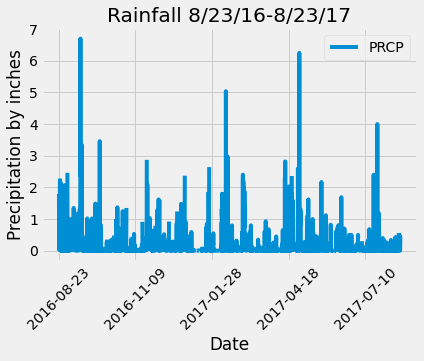

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
dateprcp_sorted_df.plot(x='Date', y='PRCP', rot=45)
plt.title("Rainfall 8/23/16-8/23/17")
plt.xlabel("Date")
plt.ylabel("Precipitation by inches")
plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
dateprcp_sorted_df.describe()

,PRCP
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [70]:
#################
#STATION ANALYSIS
#################

# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.station).count()
print(f"There are {station_count} stations in this dataset.")

There are 9 stations in this dataset.


In [71]:
# List the stations and observation counts in descending order.
#Hint: You will need to use a function such as func.min, func.max, func.avg, and func.count in your queries.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [72]:
#Which station has the highest number of observations?
stationcount = session.query(Measurement).\
    filter(Measurement.station == 'USC00519281').count()
print(f"The station with the highest number of observations is USC00519281 with {stationcount} observations")

The station with the highest number of observations is USC00519281 with 2772 observations


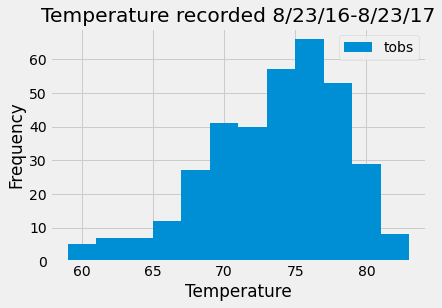

In [77]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
datetobs = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date  <= last_day_recorded).\
    filter(Measurement.date  >= one_year_ago).all()

datetobs_sorted_df =pd.DataFrame(datetobs, columns=['tobs'])
datetobs_sorted_df.plot.hist(bins=12)
plt.title("Temperature recorded 8/23/16-8/23/17")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

## Bonus Challenge Assignment

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [26]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [27]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [28]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [29]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [30]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [31]:
# Plot the daily normals as an area plot with `stacked=False`
